In [70]:
import os
import pandas as pd
import pickle
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.preprocessing.sequence import pad_sequences

folder_lifecycle = os.path.join('..', '0_dataset', 'lifecycle')

accounting preprocessing and predicting

In [71]:
# technique
df_1 = pd.read_csv(os.path.join('..', '0_dataset', 'accounting', 'label_atop.csv'), usecols=[
    'RDDSK', 'WRDSK', 'WCANCL', 'DSK', 'MINFLT', 'MAJFLT', 'VSTEXT',
    'VSIZE', 'VGROW', 'RGROW', 'MEM', 'TRUN', 'TSLPU', 'NICE', 'PRI',
    'RTPR', 'CPUNR', 'CPU', 'POLI_fifo', 'POLI_rr', 'ST_--', 'ST_-E',
    'ST_-S', 'ST_N-', 'ST_NE', 'ST_NS', 'EXC_0', 'EXC_1', 'EXC_15', 'EXC_2',
    'EXC_255', 'EXC_3', 'S_I', 'S_S', 'S_Z', 'Label', 'TIMESTAMP'
])

# # lifecycle
# df_1 = pd.read_csv(os.path.join('..', '0_dataset', 'accounting', 'lifecycle_label_atop.csv'), usecols=[
#     'RDDSK', 'WRDSK', 'WCANCL', 'DSK', 'MINFLT', 'MAJFLT', 'VSTEXT',
#     'VSIZE', 'VGROW', 'RGROW', 'MEM', 'TRUN', 'TSLPU', 'NICE', 'PRI',
#     'RTPR', 'CPUNR', 'CPU', 'POLI_fifo', 'POLI_rr', 'ST_--', 'ST_-E',
#     'ST_-S', 'ST_N-', 'ST_NE', 'ST_NS', 'EXC_0', 'EXC_1', 'EXC_15', 'EXC_2',
#     'EXC_255', 'EXC_3', 'S_I', 'S_S', 'S_Z', 'Label', 'TIMESTAMP'
# ])

df_1.drop_duplicates(keep='last', inplace=True)


# build labeling map
label_original = sorted([int(i) for i in df_1['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df_1['Label'])
origin_to_transformed = dict(zip(le.classes_, le.transform(le.classes_)))
transformed_to_origin = dict(zip(le.transform(le.classes_), le.classes_))


X = df_1.drop(columns=['Label', 'TIMESTAMP'])
accounting_result = df_1[['Label', 'TIMESTAMP']]


# feature scaling
folder = os.path.join('..', '1_preprocessing', 'scalers_accounting')
for feature_name in X.columns:
    scaler = pickle.load(open(os.path.join(folder, 'scalar_' + feature_name), 'rb'))
    X[feature_name] = scaler.transform(X[feature_name].values.reshape(-1, 1))
X = X.to_numpy()


# predict
model_path = os.path.join('models_accounting', 'XGBoost')
model = pickle.load(open(model_path, 'rb'))
y_hat = model.predict(X)

# label transfer
for i in range(len(y_hat)):
    y_hat[i] = transformed_to_origin[y_hat[i]]

accounting_result.loc[:, 'pred_accounting'] = y_hat
accounting_result.rename(columns={'Label': 'Label_accounting', 'TIMESTAMP': 'TIMESTAMP'}, inplace=True)
accounting_result['TIMESTAMP'] = accounting_result['TIMESTAMP'].astype(int)
# accounting_result.to_csv(os.path.join(folder_lifecycle, 'test.csv'), encoding='utf-8', index=False)

# merge based on time slots by soft voting
timestamps = accounting_result['TIMESTAMP'].unique()
label_unique = df_1['Label'].unique()
merged_accounting_df = pd.DataFrame()

for t in timestamps:
    voting_pred = {}
    voting_y = {}
    new_row = pd.DataFrame()
    df_tmp = accounting_result[accounting_result['TIMESTAMP'] == t]
    
    for res in df_tmp['pred_accounting'].values:
        if res in voting_pred:
            voting_pred[res] += 1
        else:
            voting_pred[res] = 1
    for res in df_tmp['Label_accounting'].values:
        if res in voting_y:
            voting_y[res] += 1
        else:
            voting_y[res] = 1
    
    base = len(df_tmp['pred_accounting'])
    new_row['TIMESTAMP'] = [t]
    for key, value in voting_pred.items():
        new_row['a_pred_' + str(key)] = [float(value) / float(base)]
    for key, value in voting_y.items():
        new_row['a_label_' + str(key)] = [float(value) / float(base)]
    
    merged_accounting_df = pd.concat([merged_accounting_df, new_row]) 

merged_accounting_df.sort_index(axis=1, inplace=True)
merged_accounting_df.to_csv(os.path.join(folder_lifecycle, 'accounting_merged.csv'), encoding='utf-8', index=False)
print(merged_accounting_df)

C:\Users\user\AppData\Local\Temp\ipykernel_16040\154614179.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounting_result.loc[:, 'pred_accounting'] = y_hat
C:\Users\user\AppData\Local\Temp\ipykernel_16040\154614179.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounting_result.rename(columns={'Label': 'Label_accounting', 'TIMESTAMP': 'TIMESTAMP'}, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_16040\154614179.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

     TIMESTAMP  a_label_0  a_label_1  a_label_10  a_label_11  a_label_12  \
0   1673430856        1.0        NaN         NaN         NaN         NaN   
0   1673430857        1.0        NaN         NaN         NaN         NaN   
0   1673430858        1.0        NaN         NaN         NaN         NaN   
0   1673430859        1.0        NaN         NaN         NaN         NaN   
0   1673430860        1.0        NaN         NaN         NaN         NaN   
..         ...        ...        ...         ...         ...         ...   
0   1673440991        1.0        NaN         NaN         NaN         NaN   
0   1673440992        1.0        NaN         NaN         NaN         NaN   
0   1673440993        1.0        NaN         NaN         NaN         NaN   
0   1673440994        1.0        NaN         NaN         NaN         NaN   
0   1673440995        1.0        NaN         NaN         NaN         NaN   

    a_label_15  a_label_16  a_label_17  a_label_2  ...  a_pred_0  a_pred_1  \
0        

log predicting

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

# technique
df_2 = pd.read_csv(os.path.join('..', '0_dataset', 'syslog', 'fix_1sec.csv'), usecols=[
    'EventTemplate', 'Label', 'Timestamp'
])
# # lifecycle
# df_2 = pd.read_csv(os.path.join('..', '0_dataset', 'syslog', 'lifecycle_fix_1sec.csv'), usecols=[
#     'EventTemplate', 'Label', 'Timestamp'
# ])
df_2.drop_duplicates(keep='last', inplace=True)


# build labeling map
label_original = sorted([int(i) for i in df_2['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df_2['Label'])
origin_to_transformed = dict(zip(le.classes_, le.transform(le.classes_)))
transformed_to_origin = dict(zip(le.transform(le.classes_), le.classes_))

max_seq_length = 1550
vocab_size = 100
# max_seq_length = 500
X = df_2['EventTemplate']
X = X.to_numpy()
for i, seq in enumerate(X):
    X[i] = seq.strip(']').strip('[').split(', ')

logs_result = df_2[['Label', 'Timestamp']]


# predict
model_path = os.path.join('models_logs', 'Bi-GRU.h5')
tokenizer_path = os.path.join('models_logs', 'tokenizer')

def tokenizing(data):
    if os.path.exists(tokenizer_path):
        tokenizer = pickle.load(open(tokenizer_path, 'rb'))
    else:
        tokenizer = Tokenizer(num_words=vocab_size)
        tokenizer.fit_on_texts(data)
        pickle.dump(tokenizer, open(tokenizer_path, 'wb'))
    
    data_tokenized = tokenizer.texts_to_sequences(data)
    max_len = 0
    for i in data_tokenized:
        max_len = max(max_len, len(i))
    print(max_len)
    data_tokenized = pad_sequences(data_tokenized, maxlen=max_seq_length)
    print(data_tokenized.shape)
    
    return data_tokenized

# # BERT
# model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})
# y_hat = model.predict(X)
# y_hat = np.argmax(y_hat, axis=1)

# other models
model = tf.keras.models.load_model(model_path, custom_objects=SeqSelfAttention.get_custom_objects())
tokenizer = pickle.load(open(tokenizer_path, 'rb'))
# X_tokenized = tokenizer.texts_to_sequences(X)
# X_tokenized = pad_sequences(X_tokenized, maxlen=max_seq_length)
X_tokenized = tokenizing(X)
y_hat = model.predict(X_tokenized)
y_hat = np.argmax(y_hat, axis=1)

# label transfer
for i in range(len(y_hat)):
    y_hat[i] = transformed_to_origin[y_hat[i]]


logs_result.loc[:, 'pred_logs'] = y_hat
logs_result.rename(columns={'Label': 'Label_logs', 'Timestamp': 'TIMESTAMP'}, inplace=True)
logs_result['TIMESTAMP'] = logs_result['TIMESTAMP'].astype(int)


# merge based on time slots by soft voting
timestamps = logs_result['TIMESTAMP'].unique()
label_unique = df_2['Label'].unique()

merged_logs_df = pd.DataFrame()

for t in timestamps:
    voting_pred = {}
    voting_y = {}
    new_row = pd.DataFrame()
    df_tmp = logs_result[logs_result['TIMESTAMP'] == t]
    
    for res in df_tmp['pred_logs'].values:
        if res in voting_pred:
            voting_pred[res] += 1
        else:
            voting_pred[res] = 1
    for res in df_tmp['Label_logs'].values:
        if res in voting_y:
            voting_y[res] += 1
        else:
            voting_y[res] = 1
    
    base = len(df_tmp['pred_logs'])
    new_row['TIMESTAMP'] = [t]
    for key, value in voting_pred.items():
        new_row['l_pred_' + str(key)] = [float(value) / float(base)]
    for key, value in voting_y.items():
        new_row['l_label_' + str(key)] = [float(value) / float(base)]
    
    merged_logs_df = pd.concat([merged_logs_df, new_row]) 

merged_logs_df.sort_index(axis=1, inplace=True)
merged_logs_df.to_csv(os.path.join(folder_lifecycle, 'logs_merged.csv'), encoding='utf-8', index=False)
print(merged_logs_df)

1534
(6713, 1550)
210/210 [==============================] - 14s 64ms/step
     TIMESTAMP  l_label_0  l_label_1  l_label_10  l_label_11  l_label_12  \
0   1673430856        1.0        NaN         NaN         NaN         NaN   
0   1673430857        1.0        NaN         NaN         NaN         NaN   
0   1673430858        1.0        NaN         NaN         NaN         NaN   
0   1673430859        1.0        NaN         NaN         NaN         NaN   
0   1673430860        1.0        NaN         NaN         NaN         NaN   
..         ...        ...        ...         ...         ...         ...   
0   1673440990        1.0        NaN         NaN         NaN         NaN   
0   1673440991        NaN        NaN         NaN         NaN         NaN   
0   1673440992        1.0        NaN         NaN         NaN         NaN   
0   1673440993        NaN        NaN         NaN         NaN         NaN   
0   1673440994        1.0        NaN         NaN         NaN         NaN   

    l_label_

traffic preprocessing and predicting

In [73]:
# technique
df_3 = pd.read_csv(os.path.join('..', '0_dataset', 'traffic', 'label_traffic.csv'), usecols=[
	'Sport', 'Dport', 'TotPkts', 'TotBytes', 'Seq', 'Dur', 'Rate',
	'DstRate', 'Flgs_ e', 'Flgs_ e *', 'Flgs_ e d', 'Flgs_ e g',
	'Flgs_ e s', 'Flgs_ eU', 'Flgs_ eUs', 'Proto_arp', 'Proto_icmp',
	'Proto_tcp', 'Proto_udp', 'State_E', 'State_INT', 'State_URH',
	'State_URP', 'State_fFR', 'State_fR', 'State_s', 'State_sEf',
	'State_sEfR', 'State_sR', 'State_sS', 'State_sSE', 'State_sSER',
	'State_sSEf', 'State_sSEfF', 'State_sSEfFR', 'State_sSEfR', 'State_sSR',
 	'StartTime', 'Label'
])
# # lifecycle
# df_3 = pd.read_csv(os.path.join('..', '0_dataset', 'traffic', 'lifecycle_label_traffic.csv'), usecols=[
# 	'Sport', 'Dport', 'TotPkts', 'TotBytes', 'Seq', 'Dur', 'Rate',
#     'DstRate', 'Flgs_ e', 'Flgs_ e   t', 'Flgs_ e *', 'Flgs_ e d',
#     'Flgs_ e d t', 'Flgs_ e g', 'Flgs_ e s', 'Flgs_ eU', 'Flgs_ eUs',
#     'Proto_arp', 'Proto_icmp', 'Proto_tcp', 'Proto_udp', 'State_E',
#     'State_ECO', 'State_ER', 'State_INT', 'State_REQ', 'State_URH',
#     'State_URP', 'State_fFR', 'State_fR', 'State_s', 'State_sE',
#     'State_sEf', 'State_sEfR', 'State_sR', 'State_sS', 'State_sSE',
#     'State_sSER', 'State_sSEf', 'State_sSEfF', 'State_sSEfFR',
#     'State_sSEfR', 'State_sSR', 'StartTime', 'Label'
# ])

df_3.drop_duplicates(keep='last', inplace=True)


# build labeling map
label_original = sorted([int(i) for i in df_3['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df_3['Label'])
origin_to_transformed = dict(zip(le.classes_, le.transform(le.classes_)))
transformed_to_origin = dict(zip(le.transform(le.classes_), le.classes_))


X = df_3.drop(columns=['Label', 'StartTime'])
traffic_result = df_3[['Label', 'StartTime']]


# feature scaling
folder = os.path.join('..', '1_preprocessing', 'scalers_traffic')
for feature_name in X.columns:
    scaler = pickle.load(open(os.path.join(folder, 'scalar_' + feature_name.replace('*', 'star')), 'rb'))
    X[feature_name] = scaler.transform(X[feature_name].values.reshape(-1, 1))
X = X.to_numpy()


# predict
model_path = os.path.join('models_traffic', 'XGBoost')
model = pickle.load(open(model_path, 'rb'))
# y_hat = model.predict_proba(X)
y_hat = model.predict(X)

# label transfer
for i in range(len(y_hat)):
    y_hat[i] = transformed_to_origin[y_hat[i]]


traffic_result.loc[:, 'pred_traffic'] = y_hat
traffic_result.rename(columns={'Label': 'Label_traffic', 'StartTime': 'TIMESTAMP'}, inplace=True)
traffic_result['TIMESTAMP'] = traffic_result['TIMESTAMP'].astype(int)


# merge based on time slots by soft voting
timestamps = traffic_result['TIMESTAMP'].unique()
label_unique = df_3['Label'].unique()

merged_traffic_df = pd.DataFrame()

for t in timestamps:
    voting_pred = {}
    voting_y = {}
    new_row = pd.DataFrame()
    df_tmp = traffic_result[traffic_result['TIMESTAMP'] == t]
    
    for res in df_tmp['pred_traffic'].values:
        if res in voting_pred:
            voting_pred[res] += 1
        else:
            voting_pred[res] = 1
    for res in df_tmp['Label_traffic'].values:
        if res in voting_y:
            voting_y[res] += 1
        else:
            voting_y[res] = 1
    
    base = len(df_tmp['pred_traffic'])
    new_row['TIMESTAMP'] = [t]
    for key, value in voting_pred.items():
        new_row['t_pred_' + str(key)] = [float(value) / float(base)]
    for key, value in voting_y.items():
        new_row['t_label_' + str(key)] = [float(value) / float(base)]
    
    merged_traffic_df = pd.concat([merged_traffic_df, new_row])

merged_traffic_df.sort_index(axis=1, inplace=True)
merged_traffic_df.to_csv(os.path.join(folder_lifecycle, 'traffic_merged.csv'), encoding='utf-8', index=False)
print(merged_traffic_df)

C:\Users\user\AppData\Local\Temp\ipykernel_16040\1795551611.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_result.loc[:, 'pred_traffic'] = y_hat
C:\Users\user\AppData\Local\Temp\ipykernel_16040\1795551611.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_result.rename(columns={'Label': 'Label_traffic', 'StartTime': 'TIMESTAMP'}, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_16040\1795551611.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

     TIMESTAMP  t_label_0  t_label_1  t_label_10  t_label_11  t_label_13  \
0   1673430856        1.0        NaN         NaN         NaN         NaN   
0   1673430857        1.0        NaN         NaN         NaN         NaN   
0   1673430858        1.0        NaN         NaN         NaN         NaN   
0   1673430859        1.0        NaN         NaN         NaN         NaN   
0   1673430860        1.0        NaN         NaN         NaN         NaN   
..         ...        ...        ...         ...         ...         ...   
0   1673440990        1.0        NaN         NaN         NaN         NaN   
0   1673440991        1.0        NaN         NaN         NaN         NaN   
0   1673440992        1.0        NaN         NaN         NaN         NaN   
0   1673440993        1.0        NaN         NaN         NaN         NaN   
0   1673440994        1.0        NaN         NaN         NaN         NaN   

    t_label_2  t_label_4  t_label_6  t_label_8  ...  t_pred_0  t_pred_1  \
0         Na

Merge methods

In [63]:
# averaging the results
def merging(sources, threshold, df, n, weight_list):
    '''
    sources: data scource types
    thresholds: thresholds[0] is threshold for prediction, thresholds[1] is threshold for ground truths
    df: confidences for each data source
    n: number of labels (techniques)
    '''
    list_time = []
    merged_label = []
    merged_pred = []
    
    # iterate by each second
    for i in range(len(df)):
        confidence_label = {}
        confidence_pred = {}
        
        # merge confidences based on weights from each data source
        for label in range(n):
            val_label = 0
            val_pred = 0
            weights_label = 0
            weights_pred = 0
            
            for j, word in enumerate(sources):
                if word == '':
                    continue
                
                col_name = str(word) + '_label_' + str(label)
                if col_name in df.columns and pd.isna(df.loc[i, col_name]) is False: # if any result in this label
                    val_label += (df[col_name][i] * weight_list[j]) # the confidences are based on weight
                    weights_label += weight_list[j]
                
                col_name = str(word) + '_pred_' + str(label)
                if col_name in df.columns and pd.isna(df.loc[i, col_name]) is False:
                    val_pred += (df[col_name][i] * weight_list[j])
                    weights_pred += weight_list[j]
            
            if weights_label > 0:
                confidence_label[label] = val_label / float(weights_label)
            
            if weights_pred > 0:
                confidence_pred[label] = val_pred / float(weights_pred)
        
        # sort by confidences
        confidence_label = dict(sorted(confidence_label.items(), key=lambda x:x[1], reverse=True))
        confidence_pred = dict(sorted(confidence_pred.items(), key=lambda x:x[1], reverse=True))
        
        # voting, threshold used for choosing 0 or not
        def voting(confidence_list, threshold):
            if len(confidence_list) == 0:
                return -1
            
            list_key = list(confidence_list)
            list_value = list(confidence_list.values())
            
            if list_key[0] == 0:
                if list_value[0] >= threshold:
                    voting_res = list_key[0]
                else:
                    voting_res = list_key[1]
            else:
                voting_res = list_key[0]
            
            return voting_res
        
        merged_label.append(voting(confidence_label, threshold[1]))
        merged_pred.append(voting(confidence_pred, threshold[0]))
        list_time.append(df['TIMESTAMP'][i])
        
    return merged_pred, merged_label, list_time

In [64]:
# # group results from each data source to sets
# def merging_multiple(sources, df):
#     '''
#     sources: data scource types
#     thresholds: thresholds[0] is threshold for prediction, thresholds[1] is threshold for ground truths
#     df: confidences for each data source
#     n: number of labels (techniques)
#     '''
#     list_time = []
#     merged_label = []
#     merged_pred = []
    
#     df_a = pd.read_csv(os.path.join(folder_lifecycle, 'results_A.csv'))
#     df_l = pd.read_csv(os.path.join(folder_lifecycle, 'results_L.csv'))
#     df_t = pd.read_csv(os.path.join(folder_lifecycle, 'results_T.csv'))
    
#     # iterate by each second
#     for i in range(len(df)):
#         res_label = set()
#         res_pred = set()
        
#         # collect highest from each source, but label 0 must higher than the threshold
#         for j, word in enumerate(sources):
#             if word == '':
#                 continue
            
#             # find prediction and label results from results_A/L/T.csv
#             if word == 'a':
#                 df_tmp = df_a
#             elif word == 'l':
#                 df_tmp = df_l
#             elif word == 't':
#                 df_tmp = df_t
            
#             res_label.add(int(df_tmp.loc[df_tmp['TIMESTAMP'] == df['TIMESTAMP'][i], 'label']))
#             res_pred.add(int(df_tmp.loc[df_tmp['TIMESTAMP'] == df['TIMESTAMP'][i], 'pred']))
        
#         merged_label.append(res_label)
#         merged_pred.append(res_pred)
#         list_time.append(df['TIMESTAMP'][i])
        
#     return merged_pred, merged_label, list_time

# # # group results from each data source to sets
# # def merging_multiple(sources, threshold, df, n):
# #     '''
# #     sources: data scource types
# #     thresholds: thresholds[0] is threshold for prediction, thresholds[1] is threshold for ground truths
# #     df: confidences for each data source
# #     n: number of labels (techniques)
# #     '''
# #     list_time = []
# #     merged_label = []
# #     merged_pred = []
    
# #     # iterate by each second
# #     for i in range(len(df)):
# #         res_label = set()
# #         res_pred = set()
        
# #         # collect highest from each source, but label 0 must higher than the threshold
# #         for j, word in enumerate(sources):
# #             if word == '':
# #                 continue
            
# #             max_label = [-1, 0] # max_label[0]: label number, max_label[1]: confidence value
# #             max_pred = [-1, 0]
# #             for label in range(n):
# #                 col_name = str(word) + '_label_' + str(label)
# #                 if col_name in df.columns and pd.isna(df.loc[i, col_name]) is False and df[col_name][i] > max_label[1]: # if any result in this label
# #                     if label == 0: # choose 0 or not
# #                         if df[col_name][i] >= threshold[1]:
# #                             max_label = [label, df[col_name][i]]
# #                     else:
# #                         max_label = [label, df[col_name][i]]
# #                     # max_label = [label, df[col_name][i]]
                
# #                 col_name = str(word) + '_pred_' + str(label)
# #                 if col_name in df.columns and pd.isna(df.loc[i, col_name]) is False and df[col_name][i] > max_pred[1]:
# #                     if label == 0: # choose 0 or not
# #                         if df[col_name][i] >= threshold[0]:
# #                             max_pred = [label, df[col_name][i]]
# #                     else:
# #                         max_pred = [label, df[col_name][i]]
# #                     # max_pred = [label, df[col_name][i]]
            
# #             res_label.add(max_label[0])
# #             res_pred.add(max_pred[0]) 
        
# #         merged_label.append(res_label)
# #         merged_pred.append(res_pred)
# #         list_time.append(df['TIMESTAMP'][i])
        
# #     return merged_pred, merged_label, list_time

group evaluation

In [65]:
def tp_num(predictions, labels):
    num = 0
    for i in range(len(predictions)):
        if predictions[i] == labels[i]:
            num += 1
    return num

def fp_num(predictions, labels):
    num = 0
    for i in range(len(predictions)):
        if predictions[i] != labels[i] and predictions[i].issuperset(labels[i]):
            num += 1
    return num

def fn_num(predictions, labels):
    num = 0
    for i in range(len(predictions)):
        if predictions[i] != labels[i] and predictions[i].issubset(labels[i]):
            num += 1
    return num

def tn_num(predictions, labels):
    num = 0
    for i in range(len(predictions)):
        if predictions[i] != labels[i] and predictions[i].issubset(labels[i]) == False and predictions[i].issuperset(labels[i]) == False:
            num += 1
    return num

def group_recall(predictions, labels):
    tp = tp_num(predictions, labels)
    fn = fn_num(predictions, labels)
    
    return float(tp) / float(tp + fn)
    
def group_precision(predictions, labels):
    tp = tp_num(predictions, labels)
    fp = fp_num(predictions, labels)
    
    return float(tp) / float(tp + fp)
    
def group_fscore(predictions, labels):
    tp = tp_num(predictions, labels)
    fp = fp_num(predictions, labels)
    fn = fn_num(predictions, labels)

    return float(2 * tp) / float(2 * tp + fp + fn)

def group_accuracy(predictions, labels):
    tp = tp_num(predictions, labels)
    fp = fp_num(predictions, labels)
    fn = fn_num(predictions, labels)
    tn = tn_num(predictions, labels)
    
    return float(tp + tn) / float(tp + tn + fp + fn)

ensemble model

In [80]:
from statistics import mean
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from collections import Counter


# # merge results
# df = pd.DataFrame()
# df = pd.merge(merged_accounting_df, merged_traffic_df, on='TIMESTAMP', how='outer')
# df = pd.merge(df, merged_logs_df, on='TIMESTAMP', how='outer')
# df.to_csv(os.path.join(folder_lifecycle, 'ensemble_confidence.csv'), encoding='utf-8', index=False)
df = pd.read_csv(os.path.join(folder_lifecycle, 'ensemble_confidence.csv'))

# technique
methods = {
    'A': [['a', '', ''], [0.87, 0.99]],
    'L': [['' , 'l', ''], [1, 1]],
    'T': [['', '', 't'], [0.98, 0.993]],
    'A+L': [['a', 'l', ''], [0.84, 0.99]],
    'A+T': [['a', '', 't'], [0.88, 0.99]],
    'L+T': [['', 'l', 't'], [0.81, 0.99]],
    'A+L+T': [['a', 'l', 't'], [0.805, 0.94]],
}

# lifecycle
# methods = {
#     'A': [['a', '', ''], [1, 1]],
#     'L': [['' , 'l', ''], [1, 1]],
#     'T': [['', '', 't'], [1, 1]],
#     'A+L': [['a', 'l', ''], [1, 1]],
#     'A+T': [['a', '', 't'], [1, 1]],
#     'L+T': [['', 'l', 't'], [1, 1]],
#     'A+L+T': [['a', 'l', 't'], [1, 1]],
# }
# methods = {
#     'A': [['a', '', ''], [0.87, 0.99]],
#     'L': [['' , 'l', ''], [1, 1]],
#     'T': [['', '', 't'], [0.98, 0.993]],
#     'A+L': [['a', 'l', ''], [0.84, 0.99]],
#     'A+T': [['a', '', 't'], [0.88, 0.99]],
#     'L+T': [['', 'l', 't'], [0.81, 0.99]],
#     'A+L+T': [['a', 'l', 't'], [0.805, 0.94]],
# }

evaluation = {}
for name in methods:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
n = 18

# set threshold and weights
# order: accounting, log, traffic
weight_list = [1, 1, 4] 
# [2,1,8]


for name, sources in methods.items():
    # if name == 'A' or name == 'L' or name == 'T':
    merged_pred, merged_label, list_time = merging(sources[0], sources[1], df, n, weight_list)
    
    # counter_pred = {}
    # for item in merged_pred:
    #     if item not in counter_pred:
    #         counter_pred[item] = 1
    #     else:
    #         counter_pred[item] +=1
    # counter_label = {}
    # for item in merged_label:
    #     if item not in counter_label:
    #         counter_label[item] = 1
    #     else:
    #         counter_label[item] +=1
    
    tmp = pd.DataFrame(list(zip(merged_pred, merged_label, list_time)), columns=['pred', 'label', 'TIMESTAMP'])
    tmp = tmp[(tmp['pred'] != -1) & (tmp['label'] != -1)]
    tmp.to_csv(os.path.join(folder_lifecycle, 'results_'+name+'.csv'), encoding='utf-8', index=False)
    preds = tmp['pred']
    labels = tmp['label']
    evaluation[name]['accuracy'].append(accuracy_score(preds, labels,))
    evaluation[name]['precision'].append(precision_score(preds, labels, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(preds, labels, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(preds, labels, average='weighted', zero_division=0))
    
    counter_pred = {}
    for item in preds:
        if item not in counter_pred:
            counter_pred[item] = 1
        else:
            counter_pred[item] +=1
    counter_label = {}
    for item in labels:
        if item not in counter_label:
            counter_label[item] = 1
        else:
            counter_label[item] +=1
    
    print(name)
    print(f'prediction threshold: {sources[1][0]}')
    print(f'label threshold: {sources[1][1]}')
    print(f'prediction: {dict(sorted(counter_pred.items()))}')
    print(f'label: {dict(sorted(counter_label.items()))}')
    print('accuracy: {:.3}\nprecision: {:.3}\nrecall: {:.3}\nf1 score: {:.3}'\
        .format(evaluation[name]['accuracy'][-1], evaluation[name]['precision'][-1], evaluation[name]['recall'][-1], evaluation[name]['f1_score'][-1]))
    
    # else :
    #     merged_pred, merged_label, list_time = merging_multiple(sources[0], df)
                
    #     print(name)
    #     # print(f'prediction threshold: {sources[1][0]}')
    #     # print(f'label threshold: {sources[1][1]}')
        
    #     tmp = pd.DataFrame(list(zip(merged_pred, merged_label, list_time)), columns=['pred', 'label', 'TIMESTAMP'])
    #     tmp.to_csv(os.path.join(folder_lifecycle, 'results_'+name+'.csv'), encoding='utf-8', index=False)
    #     evaluation[name]['accuracy'].append(group_accuracy(merged_pred, merged_label))
    #     evaluation[name]['precision'].append(group_precision(merged_pred, merged_label))
    #     evaluation[name]['recall'].append(group_recall(merged_pred, merged_label))
    #     evaluation[name]['f1_score'].append(group_fscore(merged_pred, merged_label))
    #     # merged_pred, merged_label, list_time = merging_multiple(sources[0], sources[1], df, n)
                
    #     # print(name)
    #     # print(f'prediction threshold: {sources[1][0]}')
    #     # print(f'label threshold: {sources[1][1]}')
        
    #     # tmp = pd.DataFrame(list(zip(merged_pred, merged_label, list_time)), columns=['pred', 'label', 'TIMESTAMP'])
    #     # tmp.to_csv(os.path.join(folder_lifecycle, 'results_'+name+'.csv'), encoding='utf-8', index=False)
    #     # evaluation[name]['accuracy'].append(group_accuracy(merged_pred, merged_label))
    #     # evaluation[name]['precision'].append(group_precision(merged_pred, merged_label))
    #     # evaluation[name]['recall'].append(group_recall(merged_pred, merged_label))
    #     # evaluation[name]['f1_score'].append(group_fscore(merged_pred, merged_label))
    

A
prediction threshold: 0.87
label threshold: 0.99
prediction: {0: 5942, 1: 7, 6: 820}
label: {0: 5162, 1: 823, 2: 43, 3: 1, 4: 80, 6: 49, 9: 10, 11: 599, 12: 1, 15: 1}
accuracy: 0.677
precision: 0.795
recall: 0.677
f1 score: 0.725
L
prediction threshold: 1
label threshold: 1
prediction: {0: 5081, 1: 1191, 2: 32, 4: 373, 6: 6, 8: 2, 11: 1, 14: 20, 15: 4, 17: 3}
label: {0: 2572, 1: 1955, 2: 408, 4: 415, 6: 264, 7: 87, 8: 302, 10: 86, 11: 1, 12: 98, 14: 122, 15: 139, 16: 83, 17: 181}
accuracy: 0.499
precision: 0.783
recall: 0.499
f1 score: 0.578
T
prediction threshold: 0.98
label threshold: 0.993
prediction: {0: 3201, 1: 1507, 4: 4, 9: 10, 11: 213, 13: 1031}
label: {0: 3413, 1: 1541, 2: 43, 4: 94, 6: 10, 9: 5, 11: 301, 13: 559}
accuracy: 0.875
precision: 0.908
recall: 0.875
f1 score: 0.878
A+L
prediction threshold: 0.84
label threshold: 0.99
prediction: {0: 6429, 1: 108, 2: 26, 4: 176, 6: 3, 8: 2, 14: 20, 15: 4, 17: 1}
label: {0: 5429, 1: 600, 2: 43, 4: 77, 6: 47, 9: 9, 11: 562, 12: 1, 1

evaluation

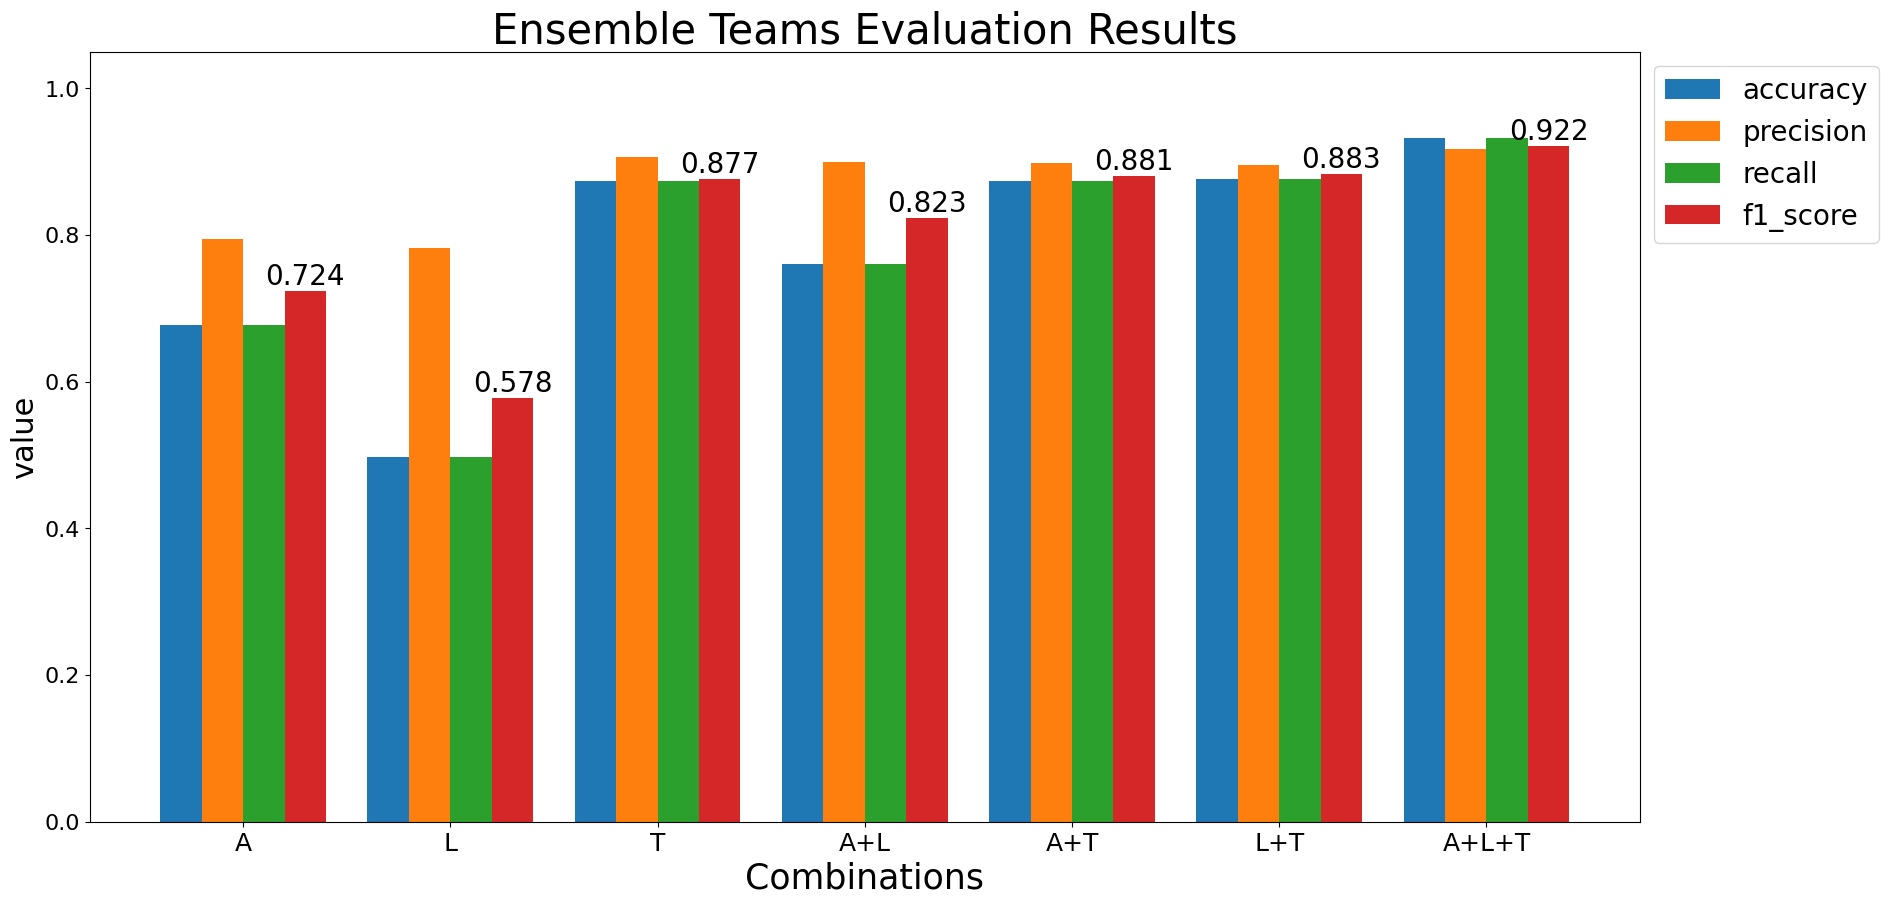

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))

width = 0.2
x = np.arange(len(methods))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Ensemble Teams Evaluation Results', fontsize=30)
plt.xticks(x+1.5*width, methods)
plt.xlabel('Combinations', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 18,
    'ytick.labelsize': 16,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.ylim(0, 1.05)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_16040\2326565687.py:16: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


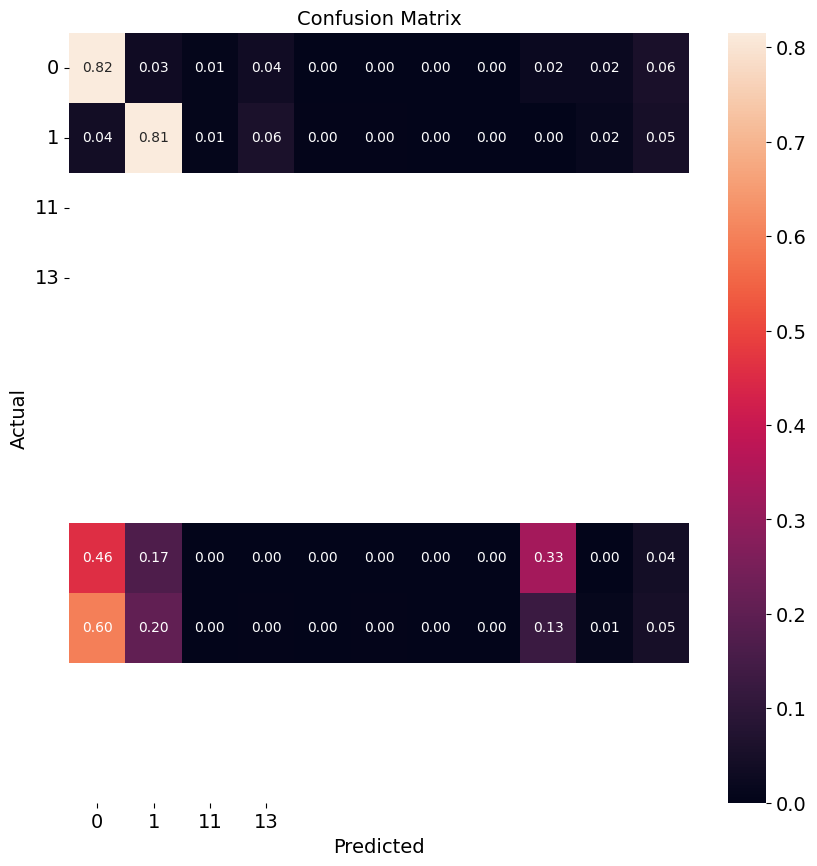

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import tree
import pickle

name = 'A+L+T'
df = pd.read_csv(os.path.join(folder_lifecycle, 'results_'+name+'.csv'))
y_hat = df['pred']
y_test = df['label']
target_names = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)